# Testing ensemble modeling calibration with synthetic data and custom models
This notebook is designed to test our ensemble modeling capability by generating synthetic data sampled from custom-made SIR-based models.

### Load dependencies and set up the notebook environment

In [1]:
import os
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyro.nn import pyro_method
from pyro.infer import Predictive
from typing import Dict, Optional

from pyciemss.PetriNetODE.base import (
    ScaledBetaNoisePetriNetODESystem,
    MiraPetriNetODESystem,
    PetriNetODESystem,
    Time,
    State,
    Solution,
    get_name,
)
from pyciemss.utils import state_flux_constraint
from pyciemss.utils import get_tspan
from pyciemss.utils.distributions import ScaledBeta

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.PetriNetODE.interfaces import sample as sample_petri
from pyciemss.PetriNetODE.interfaces import setup_model as setup_model_petri
from pyciemss.PetriNetODE.interfaces import intervene as intervene_petri
from pyciemss.PetriNetODE.interfaces import calibrate as calibrate_petri

from pyciemss.Ensemble.interfaces import setup_model as setup_model_ensemble
from pyciemss.Ensemble.interfaces import reset_model as reset_model_ensemble
from pyciemss.Ensemble.interfaces import intervene as intervene_ensemble
from pyciemss.Ensemble.interfaces import sample as sample_ensemble
from pyciemss.Ensemble.interfaces import calibrate as calibrate_ensemble
from pyciemss.Ensemble.interfaces import optimize as optimize_ensemble

### Plotting utilities

In [2]:
COLORS=['red','green','blue','black','gold','purple','orangered']
# TODO: Add plot title, axis labels

def plot_trajectories(sol, tspan, num_params, data=None):
    # Chooses plot colors so that, for example, S is always green, I is always red, etc.
    color_key = [1, 0, 4, 2, 3]
    if num_params > 6:
        color_key = [1, 5, 0, 6, 4, 2, 3]
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate(list(sol.keys())[num_params:]): # skip parameters
        
        if len(sol[list(sol.keys())[3]]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[color_key[i]], alpha=0.5, lw=3, label=var)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan[indices], I_low[indices], I_up[indices],
                            alpha=0.2, color=COLORS[color_key[i]], label=var)
        
        if var[:-4] in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[color_key[i]])
    
    ax.legend()

# Make some models

### Model 1: SIRHD
Model 1 state variables: Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}SI\\ 
\frac{dI}{dt} &= \frac{\beta}{N}SI - \gamma I\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \frac{1 - dh}{los}H\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\gamma$ recovery rate, $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [3]:
class SIRHD(PetriNetODESystem):
    # Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: infection rate
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "infectious_population": 1, "recovered_population": 2, 
                "hospitalized_population": 3, "deceased_population": 4}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, I, R, H, D = state
        dSdt = -self.beta * S * I / self.total_population
        dIdt = self.beta * S * I / self.total_population - self.gamma * I
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + ((1 - self.dh)/self.los) * H
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dIdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

In [4]:
# Define the start state
def create_start_state_inf(total_population):

    returned_state = {}
    returned_state["infectious_population"] = 1
    returned_state["recovered_population"] = 0
    returned_state["hospitalized_population"] = 0
    returned_state["deceased_population"] = 0
    returned_state["susceptible_population"] = total_population - sum(returned_state.values())
    
    assert(returned_state["susceptible_population"] > 0)
    return {k:v/total_population for k, v in returned_state.items()}
#     return {k:v for k, v in returned_state.items()}

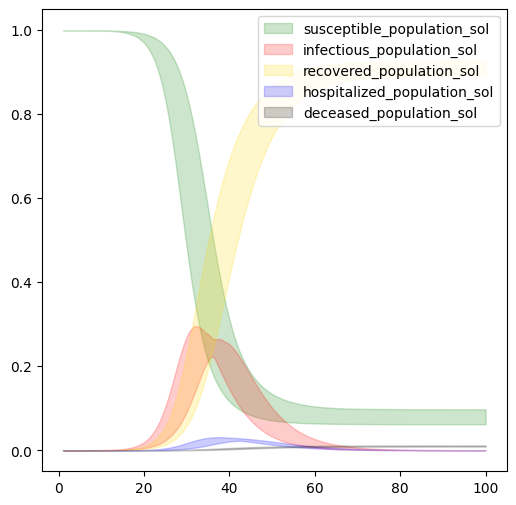

In [5]:
full_tspan = get_tspan(1, 100, 1000)
N = 100000.0 # total population
SIRHD_raw  = SIRHD(N=N, beta=0.55, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SIRHD_model = setup_model_petri(SIRHD_raw, start_time=0, start_state=create_start_state_inf(N))
model1_solution   = sample_petri(SIRHD_model, full_tspan, 10)

num_params = 6
plot_trajectories(model1_solution, full_tspan, num_params)
plt.show()

### Model 2: SEIARHD
Model 2 state variables: Susceptible (S), **Exposed** (E), **Symptomatic Infectious** (I), **Asymptomatic Infectious** (A), Recovered (R), Hospitalized (H), and Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}S(\delta I + A)\\ 
\frac{dE}{dt} &= \frac{\beta}{N}S(\delta I + A) - \frac{1}{\alpha} E\\
\frac{dI}{dt} &= \frac{pS}{\alpha}E - \gamma I\\
\frac{dA}{dt} &= \frac{1 - pS}{\alpha}E - \gamma A\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \gamma A + \frac{1 - dh}{los}H\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\delta$ difference in infectiousness symptomatic:asymptomatic (assume symptomatic individuals are more infectious than asymptomatic), $\alpha$ latency period (the average length of time between transmission and becoming infectious/showing symptoms), $pS$ percent of exposures which become symptomatic, $\gamma$ recovery rate (equal to 1/infectious_period), $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [6]:
class SEIARHD(PetriNetODESystem):
    # Susceptible (S), Exposed(E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            delta: float,
            alpha: float,
            pS: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: transmission rate
        :param delta: difference in infectiousness symptomatic/asymptomatic
        :param alpha: latency period
        :param pS: percent of exposures which become symptomatic
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.delta_prior = pyro.distributions.Uniform(max(0.9 * delta, 0.0), 1.1 * delta)
        self.alpha_prior = pyro.distributions.Uniform(max(0.9 * alpha, 0.0), 1.1 * alpha)
        self.pS_prior = pyro.distributions.Uniform(max(0.9 * pS, 0.0), 1.1 * pS)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "exposed_population": 1, "symptomatic_population": 2, 
                "asymptomatic_population": 3, "recovered_population": 4, 
                "hospitalized_population": 5, "deceased_population": 6}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, E, I, A, R, H, D = state
        dSdt = -self.beta * S * (self.delta * I + A) / self.total_population
        dEdt = self.beta * S * (self.delta * I + A) / self.total_population - (1/self.alpha) * E
        dIdt = (self.pS/self.alpha) * E - self.gamma * I
        dAdt = ((1 - self.pS)/self.alpha) * E - self.gamma * A
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + self.gamma * A + ((1 - self.dh)/self.los) * H
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dEdt, dIdt, dAdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'delta', pyro.sample('delta', self.delta_prior))
        setattr(self, 'alpha', pyro.sample('alpha', self.alpha_prior))
        setattr(self, 'pS', pyro.sample('pS', self.pS_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

In [7]:
def create_start_state_symp(total_population):

    returned_state = {}
    returned_state["exposed_population"] = 0
    returned_state["symptomatic_population"] = 1
    returned_state["asymptomatic_population"] = 0
    returned_state["recovered_population"] = 0
    returned_state["hospitalized_population"] = 0
    returned_state["deceased_population"] = 0
    returned_state["susceptible_population"] = total_population - sum(returned_state.values())
    
    assert(returned_state["susceptible_population"] > 0)
    return {k:v/total_population for k, v in returned_state.items()}

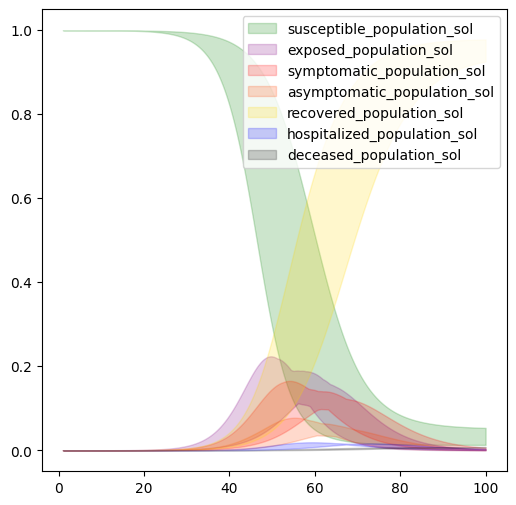

In [8]:
full_tspan = get_tspan(1, 100, 1000)
N = 100000.0 # total population
SEIARHD_raw  = SEIARHD(N=N, beta=0.55, delta=1.5, alpha=4, pS=0.7, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SEIARHD_model = setup_model_petri(SEIARHD_raw, start_time=0, start_state=create_start_state_symp(N))
model2_solution   = sample_petri(SEIARHD_model, full_tspan, 10)

num_params = 9
plot_trajectories(model2_solution, full_tspan, num_params)
plt.show()

### Model 3: SEIARHDS
SEIARHDS is the same as Model 2, but with a return to *Susceptible* from *Recovered* \
Model 3 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}S(\delta I + A) + \frac{1}{\tau}R\\ 
\frac{dE}{dt} &= \frac{\beta}{N}S(\delta I + A) - \frac{1}{\alpha} E\\
\frac{dI}{dt} &= \frac{pS}{\alpha}E - \gamma I\\
\frac{dA}{dt} &= \frac{1 - pS}{\alpha}E - \gamma A\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \gamma A + \frac{1 - dh}{los}H - \frac{1}{\tau}R\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\delta$ difference in infectiousness symptomatic:asymptomatic (assume symptomatic individuals are more infectious than asymptomatic), $\tau$ period of immunity from recovery, $\alpha$ latency period (the average length of time between transmission and becoming infectious/showing symptoms), $pS$ percent of exposures which become symptomatic, $\gamma$ recovery rate (equal to 1/infectious_period), $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [9]:
class SEIARHDS(PetriNetODESystem):
    # Susceptible (S), Exposed(E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            delta: float,
            tau: float,
            alpha: float,
            pS: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: transmission rate
        :param delta: difference in infectiousness symptomatic/asymptomatic
        :param tau: immunity period
        :param alpha: latency period
        :param pS: percent of exposures which become symptomatic
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.delta_prior = pyro.distributions.Uniform(max(0.9 * delta, 0.0), 1.1 * delta)
        self.tau_prior = pyro.distributions.Uniform(max(0.9 * tau, 0.0), 1.1 * tau)
        self.alpha_prior = pyro.distributions.Uniform(max(0.9 * alpha, 0.0), 1.1 * alpha)
        self.pS_prior = pyro.distributions.Uniform(max(0.9 * pS, 0.0), 1.1 * pS)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "exposed_population": 1, "symptomatic_population": 2, 
                "asymptomatic_population": 3, "recovered_population": 4, 
                "hospitalized_population": 5, "deceased_population": 6}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, E, I, A, R, H, D = state
        dSdt = -self.beta * S * (self.delta * I + A) / self.total_population + (1/self.tau) * R
        dEdt = self.beta * S * (self.delta * I + A) / self.total_population - (1/self.alpha) * E
        dIdt = (self.pS/self.alpha) * E - self.gamma * I
        dAdt = ((1 - self.pS)/self.alpha) * E - self.gamma * A
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + self.gamma * A + ((1 - self.dh)/self.los) * H - (1/self.tau) * R
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dEdt, dIdt, dAdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'delta', pyro.sample('delta', self.delta_prior))
        setattr(self, 'tau', pyro.sample('tau', self.tau_prior))
        setattr(self, 'alpha', pyro.sample('alpha', self.alpha_prior))
        setattr(self, 'pS', pyro.sample('pS', self.pS_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

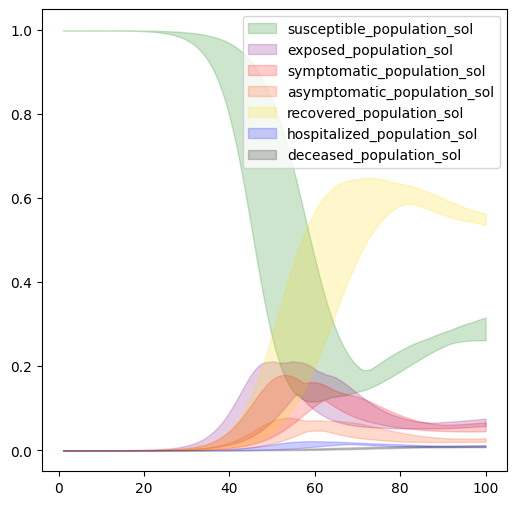

In [10]:
full_tspan = get_tspan(1, 100, 1000)
N = 100000.0 # total population
SEIARHDS_raw  = SEIARHDS(N=N, beta=0.55, delta=1.5, tau=30, alpha=4, pS=0.7, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SEIARHDS_model = setup_model_petri(SEIARHDS_raw, start_time=0, start_state=create_start_state_symp(N))
model3_solution   = sample_petri(SEIARHDS_model, full_tspan, 10)

num_params = 10
plot_trajectories(model3_solution, full_tspan, num_params)
plt.show()

# Form synthetic dataset from model output

In [11]:
# Define type of solution mapping required by each model
def solution_mapping_inf(model_solution: dict) -> dict:
    # solution mapping for models with one infectious category
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["infectious_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

def solution_mapping_symp(model_solution: dict) -> dict:
    # solution mapping for models with a symptomatic and an asymptomatic population
    mapped_dict = {}
    mapped_dict["Cases"] = model_solution["symptomatic_population"] + model_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model_solution["deceased_population"]
    return mapped_dict

In [12]:
# Run one sample of each model to use in synthetic dataset
model1_sample   = sample_petri(SIRHD_model, full_tspan, 1)
model2_sample   = sample_petri(SEIARHD_model, full_tspan, 1)
model3_sample   = sample_petri(SEIARHDS_model, full_tspan, 1)
print(f"Model 1 sample transmission rate (beta): {model1_sample['beta']}")
print(f"Model 2 sample transmission rate (beta): {model2_sample['beta']}")
print(f"Model 3 sample transmission rate (beta): {model3_sample['beta']}")

Model 1 sample transmission rate (beta): tensor([0.5171])
Model 2 sample transmission rate (beta): tensor([0.5649])
Model 3 sample transmission rate (beta): tensor([0.5480])


## Create synthetic data from (up to 3) model samples and desired weights

In [13]:
# Function that takes in any number (up to 3) of the previously defined model samples along with a set of weights,
# and returns the weighted sum of the sample output, aka the synthetic data DataFrame: synth_data_df, as well as the
# dictionary sample_data containing the original model output.

# Note that hard-coded into the function are the start date 11/29/2021, and 100 as the number of time points

def create_synth_data(weights, modelA_sample, modelB_sample=None, modelC_sample=None):
# must include one weight per model, weights must be positive and sum to 1

    num_models = len(weights)
    sample_array = [modelA_sample, modelB_sample, modelC_sample]
    
    # Create synth_data dictionary, a dictionary of dictionaries which has models as keys, and dictionaries
    # containing their outputs (mapped to keys: Cases, Hospitalizations, and Deaths) as values
    sample_data = {}
    for i in range(num_models):
        
        # Map state variables to data and save output to synth_data dictionary
        state_var_sol_dict = {}
        for n in sample_array[i].keys():
            if "population" in n:
                state_var_sol_dict[n[0:-4]] = sample_array[i][n]
            
        if "symptomatic_population" in state_var_sol_dict.keys():
            sample_data['model' + str(i)] = solution_mapping_symp(state_var_sol_dict)

        else:
            sample_data['model' + str(i)] = solution_mapping_inf(state_var_sol_dict)
        #print(sample_data['model' + str(i)].keys())
        
    print(sample_data.keys())

    # Create a DataFrame containing the weighted sum of the different model solutions for each variable
    model_weights = dict(zip(sample_data.keys(), weights)) 
    var_names = sample_data['model0'].keys()
    synth_data_dict = {}
    for vn in var_names:
        this_var = 0*sample_data['model0'][vn][0]
        for mn in sample_data.keys():
            this_var = this_var + model_weights[mn]*sample_data[mn][vn][0]
        synth_data_dict[vn] = this_var.numpy()
    synth_data_df = pd.DataFrame.from_dict(synth_data_dict)

    # Keep only integer time values so there's one data point per day
    N_t = 100
    t_points = get_tspan(1, N_t, 10*(N_t - 1) + 1)
    keep_idx = [i for i,t in enumerate(t_points) if int(t) == t] 
    synth_data_df = synth_data_df.iloc[keep_idx]

    # Add a date column
    from datetime import date, timedelta, datetime
    start_date = date(2021, 11, 29)
    date_col = [start_date]*len(synth_data_df)
    for i in range(len(synth_data_df)):
        date_col[i] = f"{start_date + timedelta(days = i)}"
    synth_data_df["Date"] = date_col
    synth_data_df = synth_data_df.iloc[:, [3, 0, 1, 2]]

    # Reset DataFrame index
    synth_data_df = synth_data_df.reset_index(drop = True)
    
    return synth_data_df, sample_data


In [14]:
# Create synthetic data using generating weights
generating_weights = [0.5, 0.3, 0.2]
[synth_data_df, sample_data] = create_synth_data(generating_weights, model1_sample, model2_sample, model3_sample)

# Make a separate dataframe to hold all output from all timpoints for each model independently
model1_df = pd.DataFrame.from_dict({k: sample_data['model0'][k][0] for k in sample_data['model0']})
model2_df = pd.DataFrame.from_dict({k: sample_data['model1'][k][0] for k in sample_data['model1']})
model3_df = pd.DataFrame.from_dict({k: sample_data['model2'][k][0] for k in sample_data['model2']})

# Alternatively, you can get a DataFrame for a single model with a Date column like this:
[model1_data_df, model1_sample_data] = create_synth_data([1], model1_sample)
# Only now, model1_data_df has a date column and only includes one data point per day 
# len(model1_df) = 1000, len(model1_data_df) = 100

dict_keys(['model0', 'model1', 'model2'])
dict_keys(['model0'])


# Add noise and plot synthetic data

In [15]:
# Plotting utility
def plot_observations(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data, color, alpha=alpha, lw=lw, marker=marker, label=label)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    return ax

In [16]:
# Function that accepts a DataFrame and level of noise as inputs, and returns and plots the noisy data.
def add_noise(data_df, noise_level, to_plot=True):
    import copy
    noisy_data_df = copy.deepcopy(data_df)
    row_num = len(noisy_data_df)
    col_names = ["Cases", "Hospitalizations", "Deaths"]
    col_num = len(col_names)
    noisy_data_df[col_names] = abs(noisy_data_df[col_names] + np.multiply(noise_level * noisy_data_df[col_names], np.random.randn(row_num, col_num)))
    
    keep_idx = np.arange(len(full_tspan))
    keep_idx = keep_idx[0::10]
    if to_plot:
        for i in range(col_num):    
            var_name = col_names[i]
            ax = plot_observations(model1_df[var_name], full_tspan, color="red", label="Model1 " + var_name)
            ax = plot_observations(model2_df[var_name], full_tspan, ax=ax, color="blue", label="Model2 " + var_name)
            ax = plot_observations(model3_df[var_name], full_tspan, ax=ax, color="orange", label="Model3 " + var_name)
            ax = plot_observations(data_df[var_name], full_tspan[keep_idx], ax=ax, color="black", label="Synth " + var_name)
            ax = plot_observations(noisy_data_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy Synth " + var_name)
            ax.set_title("Synthetic " + var_name[:-1] + " Data")
            ax.set_xlabel("Time (days)")
            ax.set_ylabel("Number of People")
    
    return noisy_data_df 

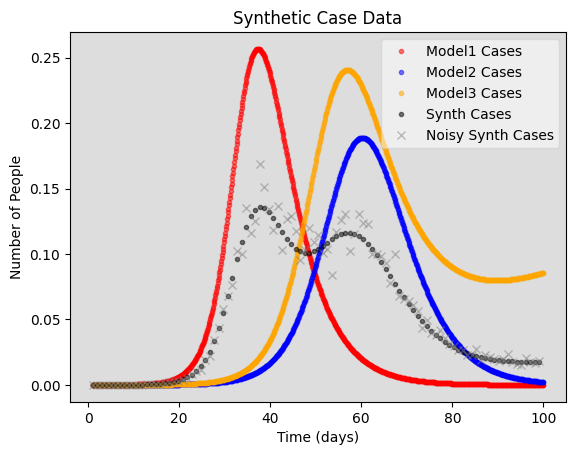

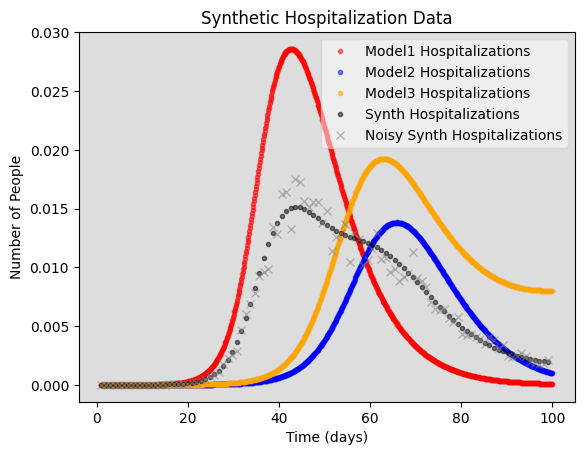

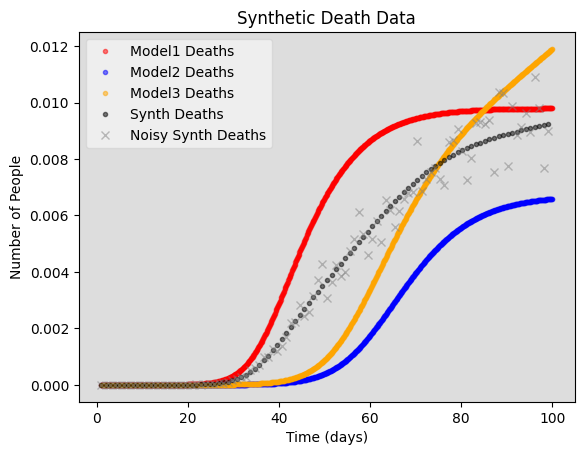

In [17]:
synth_data_noisy_df = add_noise(synth_data_df, 0.1)
#display(synth_data_noisy_df)

dict_keys(['model0'])
dict_keys(['model0'])
dict_keys(['model0'])


Text(0, 0.5, 'Number of People')

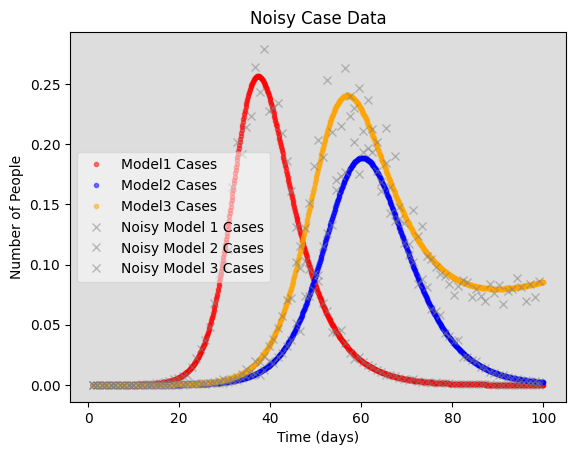

In [18]:
# Make and plot noisy data from each model individually

# These won't include a Date column for calibration purposes
# model1_noisy_df = add_noise(model1_df, 0.1, to_plot=False)
# model2_noisy_df = add_noise(model2_df, 0.1, to_plot=False)
# model3_noisy_df = add_noise(model3_df, 0.1, to_plot=False)

# These DataFrames include a Date column and can be used for calibration
[model1_data_df, model1_sample_data] = create_synth_data([1], model1_sample)
model1_noisy_df = add_noise(model1_data_df, 0.1, to_plot=False)
[model2_data_df, model2_sample_data] = create_synth_data([1], model2_sample)
model2_noisy_df = add_noise(model2_data_df, 0.1, to_plot=False)
[model3_data_df, model3_sample_data] = create_synth_data([1], model3_sample)
model3_noisy_df = add_noise(model3_data_df, 0.1, to_plot=False)

var_name = "Cases"
plot_all_data = True
keep_idx = np.arange(len(full_tspan))
keep_idx = keep_idx[0::10]
if plot_all_data:
    ax = plot_observations(model1_df[var_name], full_tspan, color="red", label="Model1 " + var_name)
    ax = plot_observations(model2_df[var_name], full_tspan, ax=ax, color="blue", label="Model2 " + var_name)
    ax = plot_observations(model3_df[var_name], full_tspan, ax=ax, color="orange", label="Model3 " + var_name)
else:
    ax = plot_observations(model1_data_df[var_name], full_tspan[keep_idx], color="red", label="Model1 " + var_name)
    ax = plot_observations(model2_data_df[var_name], full_tspan[keep_idx], ax=ax, color="blue", label="Model2 " + var_name)
    ax = plot_observations(model3_data_df[var_name], full_tspan[keep_idx], ax=ax, color="orange", label="Model3 " + var_name)
ax = plot_observations(model1_noisy_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy Model 1 " + var_name)
ax = plot_observations(model2_noisy_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy Model 2 " + var_name)
ax = plot_observations(model3_noisy_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy Model 3 " + var_name)
ax.set_title("Noisy " + var_name[:-1] + " Data")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Number of People")

# Test Ensemble Model Calbration

In [19]:
# More plotting utilities
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time since start of pandemic (days)')
    ax.set_ylabel('Cases (Prop. of Population)')
    ax.set_yscale('log')
    return ax

def plot_predictive(prediction, tspan, var_name="Cases_sol", ax=None, title=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)
    indeces = torch.ones_like(tspan).bool()
    
    I_low = torch.quantile(prediction[var_name], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction[var_name], 0.95, dim=0).detach().numpy()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

### Set up train and test data

In [20]:
# Function to prepare train and test data
def get_train_test_data(data: pd.DataFrame, train_start_date: str, test_start_date: str, test_end_date: str) -> pd.DataFrame:
    
    train_df = data[(data['date'] >= train_start_date) & (data['date'] < test_start_date)]
    train_data = [0] * train_df.shape[0]
    start_time = train_df.index[0]

    train_cases = np.array(train_df["case_census"].astype("float")) #/ data_total_population
    train_timepoints = np.array(train_df.index.astype("float"))

    test_df = data[(data['date'] >= test_start_date) & (data['date'] < test_end_date)]
    test_cases = np.array(test_df["case_census"].astype("float")) #/ data_total_population
    test_timepoints = np.array(test_df.index.astype("float"))

    for time, row in train_df.iterrows():
        row_dict = {}
        row_dict["Cases"] = row["case_census"] #/ data_total_population
        row_dict["Deaths"] = row["cumulative_deaths"] #/ data_total_population
        if row["hospital_census"] > 0:
            row_dict["Hospitalizations"] = row["hospital_census"] #/ data_total_population

        index = time - start_time
        train_data[index] = (float(time), row_dict)
    
    all_timepoints = np.concatenate((train_timepoints, test_timepoints))

    return train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints

In [21]:
# Get train and test data, set start time
train_start_date = "2021-12-01"
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"

# Choose DataFrame (synth_data_df, synth_data_noisy_df, model1_noisy_df, etc.)
data_to_use_df = synth_data_noisy_df

# Change dataframe column names to match expected testing data format
data_to_use_df = data_to_use_df.rename(columns = {"Date": "date", 
                                            "Cases": "case_census",
                                            "Hospitalizations": "hospital_census",
                                            "Deaths": "cumulative_deaths", 
                                             })

train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(data_to_use_df, train_start_date, test_start_date, test_end_date)
start_time = train_timepoints[0] - 1e-5

### Set up and sample the ensemble model

In [22]:
# Set up the ensemble model

# Initial guess: each model contributes equally
ensemble_weights = [1/3, 1/3, 1/3]

models = [SIRHD_model, SEIARHD_model, SEIARHDS_model]
N = 100000 # total population
start_states = [create_start_state_inf(N), create_start_state_symp(N), create_start_state_symp(N)]
solution_mappings = [solution_mapping_inf, solution_mapping_symp, solution_mapping_symp]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model_ensemble(models, 
                       ensemble_weights, 
                       solution_mappings, 
                       start_time, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [SIRHD(), SEIARHD(), SEIARHDS()]

In [23]:
# Function to plot ensemble prior and posterior with data
def plot_prior_posterior(data_df, ensemble_prior_forecasts, calibrated_solution=None):
    ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
    if not (calibrated_solution == None):
        ax = plot_predictive(calibrated_solution, all_timepoints, ax=ax, title="Posterior Forecasts - Ensemble", color="red", label="Ensemble Model Posterior Forecasts")
    ax = plot_observations(data_df, all_timepoints, ax=ax, color="black", label="Reported Cases")

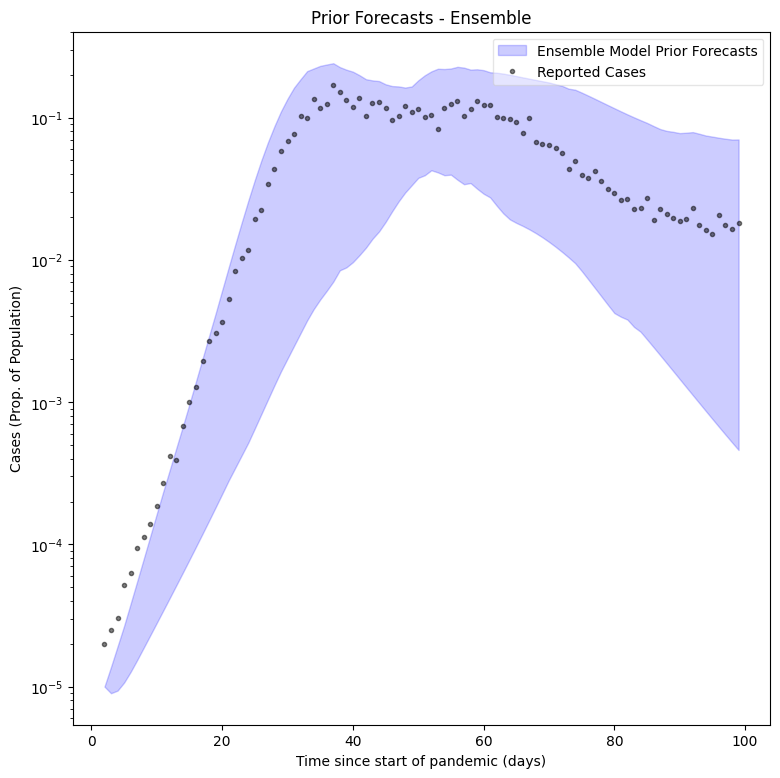

In [24]:
# Sample from the ensemble prior
num_samples = 100
ensemble_prior_forecasts = sample_ensemble(ensemble, all_timepoints, num_samples)
plot_prior_posterior(data_to_use_df['case_census'][2:], ensemble_prior_forecasts)

### Perform model calibration and plot the results

In [25]:
num_iterations = 200
autoguide = pyro.infer.autoguide.AutoDiagonalNormal
inferred_parameters = calibrate_ensemble(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

inferred_parameters

iteration 0: loss = -796.861847281456
iteration 10: loss = -870.3319897651672
iteration 20: loss = -904.5569578409195
iteration 30: loss = -914.209925532341
iteration 40: loss = -922.7386522293091
iteration 50: loss = -920.4200860261917
iteration 60: loss = -933.0519424676895
iteration 70: loss = -932.9152745008469
iteration 80: loss = -941.9758602380753
iteration 90: loss = -946.8667956590652
iteration 100: loss = -946.8595620393753
iteration 110: loss = -946.2958815097809
iteration 120: loss = -956.845620393753
iteration 130: loss = -949.922772526741
iteration 140: loss = -948.9756671190262
iteration 150: loss = -950.5019264221191
iteration 160: loss = -954.9071934223175
iteration 170: loss = -957.7142176628113
iteration 180: loss = -950.6716567277908
iteration 190: loss = -953.7863508462906


AutoDiagonalNormal()

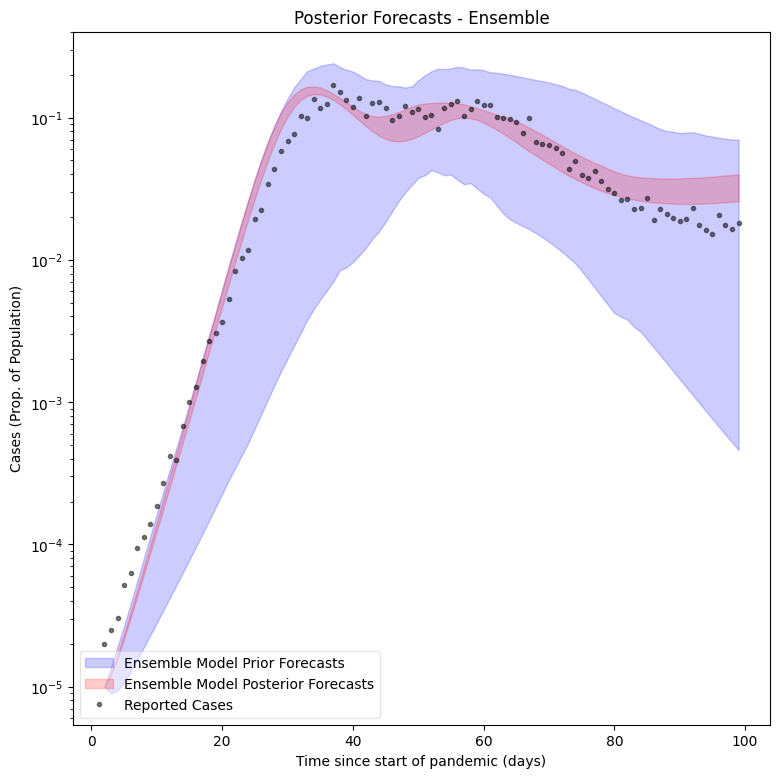

In [26]:
# Sample from the calibrated ensemble model and plot the results
calibrated_solution = sample_ensemble(ensemble, timepoints=all_timepoints, num_samples=50, inferred_parameters=inferred_parameters)
plot_prior_posterior(data_to_use_df['case_census'][2:], ensemble_prior_forecasts, calibrated_solution)

In [34]:
# Function that accepts generating weights and a calibrated ensemble model solution as inputs, and makes a 
# box plot of the ensemble weights to compare with the generating weights

def plot_weights(generating_weights, calibrated_solution):
    fig = plt.figure(facecolor='w', figsize=(9, 9))
    ax = fig.add_subplot(111, axisbelow=True)
    num_models = len(calibrated_solution["model_weights"][0])
    if (num_models == 1):
        weight_df = pd.DataFrame({"Model 1 Weight": calibrated_solution["model_weights"][:, 0]})
    elif (num_models == 2): 
        weight_df = pd.DataFrame({"Model 1 Weight": calibrated_solution["model_weights"][:, 0], 
                            "Model 2 Weight": calibrated_solution["model_weights"][:, 1]})
    else:
        weight_df = pd.DataFrame({"Model 1 Weight": calibrated_solution["model_weights"][:, 0], 
                            "Model 2 Weight": calibrated_solution["model_weights"][:, 1],
                            "Model 3 Weight": calibrated_solution["model_weights"][:, 2]})
            
    weight_df.boxplot()
    COLOR = ["orange", "blue", "green"]
    for i in range(num_models):
        plt.plot((i + 1), generating_weights[i], mfc = COLOR[i], mec='k', ms=7, marker="o", linestyle="None", label="Model " + str(i + 1) + " Generating Weight")
    plt.title("Distribution of Calibrated Ensemble Model Weights")
    plt.legend()

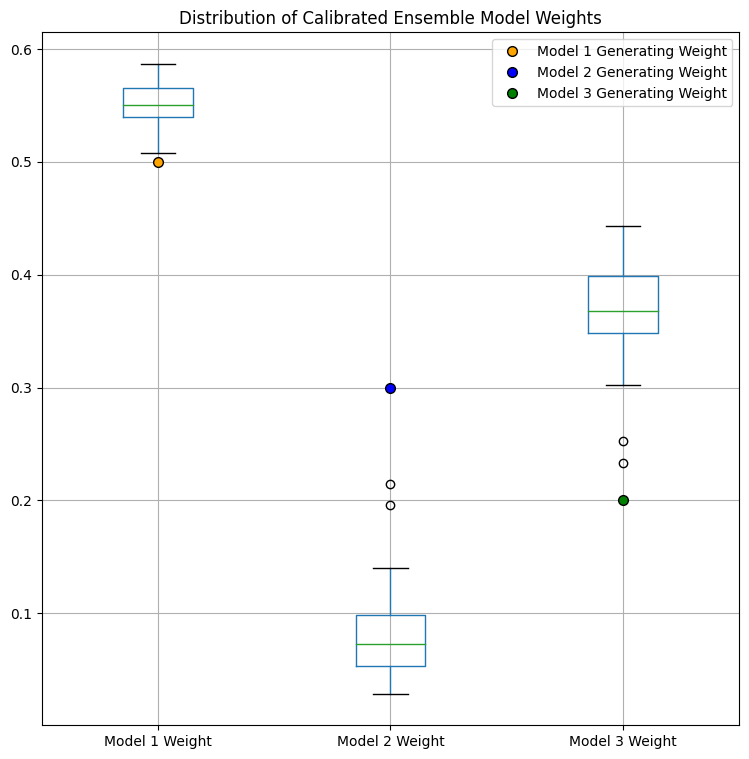

In [38]:
# Make a box plot of model weights from each sample
plot_weights(generating_weights, calibrated_solution)

# Repeat steps above for different weights, and model combinations

In [29]:
# Assume you already have model1_sample, model2_sample, model3_sample
# model_order gives (in order) the number of model used to generate each sample, for example, if sample1
# is from Model 1 (SIRHD), and sample2 and sample3 are from Model 3 (SEIARHDS), model_list = [1, 3, 3]
# Train/test intervals are hard-coded, as is the total_pop

def ensemble_weight_comparison(generating_weights, additive_noise_level, model_order, ensemble_weights, sample1, sample2, sample3):
    
    [synthetic_data_df, sample_data] = create_synth_data(generating_weights, sample1, sample2, sample3)
    noisy_data_df = add_noise(synthetic_data_df, additive_noise_level, to_plot=False)
    noisy_data_df = noisy_data_df.rename(columns = {"Date": "date", 
                                            "Cases": "case_census",
                                            "Hospitalizations": "hospital_census",
                                            "Deaths": "cumulative_deaths", 
                                             })
    
    # Get train and test data, set start time
    train_start_date = "2021-12-01"
    test_start_date = "2022-03-01"
    test_end_date = "2022-04-01"
    train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(noisy_data_df, train_start_date, test_start_date, test_end_date)
    start_time = train_timepoints[0] - 1e-5

    # Set up the ensemble model
    #ensemble_weights = [1/3, 1/3, 1/3] # Initial guess for ensemble weights: each model contributes equally

    N = 100000 # total population
    models = [SIRHD_model, SEIARHD_model, SEIARHDS_model]
    start_states = [create_start_state_inf(N), create_start_state_symp(N), create_start_state_symp(N)]
    solution_mappings = [solution_mapping_inf, solution_mapping_symp, solution_mapping_symp]
    if not (model_order == [1, 2, 3]):
        model_order = [i - 1 for i in model_order]
        models = [models[i] for i in model_order]
        start_states = [start_states[i] for i in model_order]
        solution_mappings = [solution_mappings[i] for i in model_order]
        generating_weights = [generating_weights[i] for i in model_order]
        ensemble_weights = [ensemble_weights[i] for i in model_order]

    ensemble_total_population = 1.0
    dirichlet_concentration = 1.0
    noise_pseudocount = 100.0
    ensemble = setup_model_ensemble(models, 
                           ensemble_weights, 
                           solution_mappings, 
                           start_time, 
                           start_states, 
                           ensemble_total_population, 
                           dirichlet_concentration=dirichlet_concentration,
                           noise_pseudocount=noise_pseudocount)
    display(ensemble)
    
    # Sample from the ensemble prior
    num_samples = 100
    ensemble_prior_forecasts = sample_ensemble(ensemble, all_timepoints, num_samples)
    
    # Plot ensemble prior distribution with synthetic data
    plot_prior_posterior(noisy_data_df['case_census'][2:], ensemble_prior_forecasts)
    
    # Calibrate the ensemble model to the synthetic data
    num_iterations = 100
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate_ensemble(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)
    calibrated_solution = sample_ensemble(ensemble, timepoints=all_timepoints, num_samples=50, inferred_parameters=inferred_parameters)

    # Plot ensemble output with synthetic data
    plot_prior_posterior(noisy_data_df['case_census'][2:], ensemble_prior_forecasts, calibrated_solution)

    # Make a box plot of model weights from each sample
    plot_weights(generating_weights, calibrated_solution)
    

### A few examples

dict_keys(['model0', 'model1', 'model2'])


Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [SIRHD(), SEIARHD(), SEIARHDS()]

iteration 0: loss = -782.5843849182129
iteration 10: loss = -853.8561434745789
iteration 20: loss = -876.6798993349075
iteration 30: loss = -897.2313115596771
iteration 40: loss = -919.2919265031815
iteration 50: loss = -922.8750195503235
iteration 60: loss = -935.3550622463226
iteration 70: loss = -936.01000893116
iteration 80: loss = -935.6601762771606
iteration 90: loss = -946.9030342102051


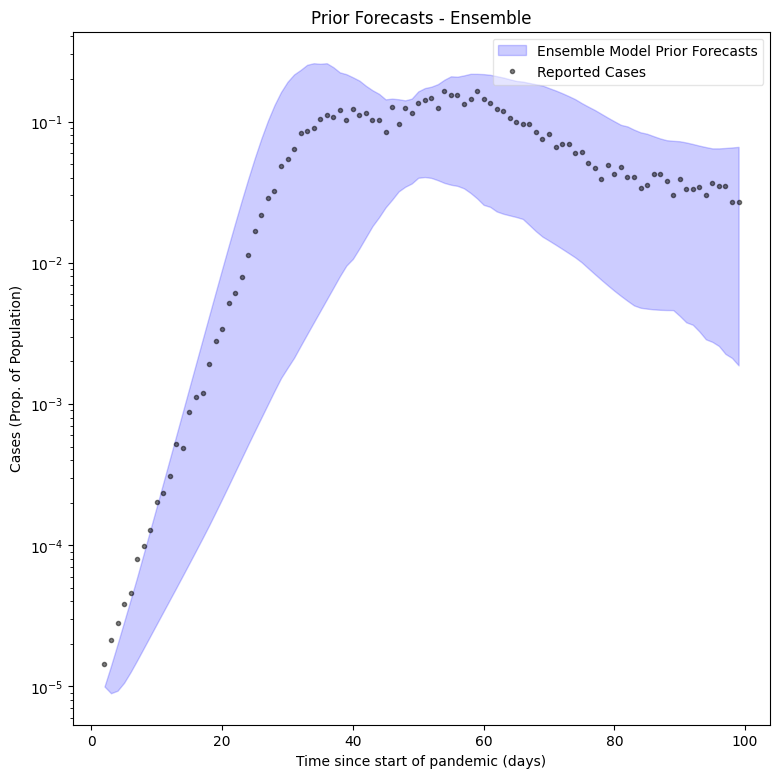

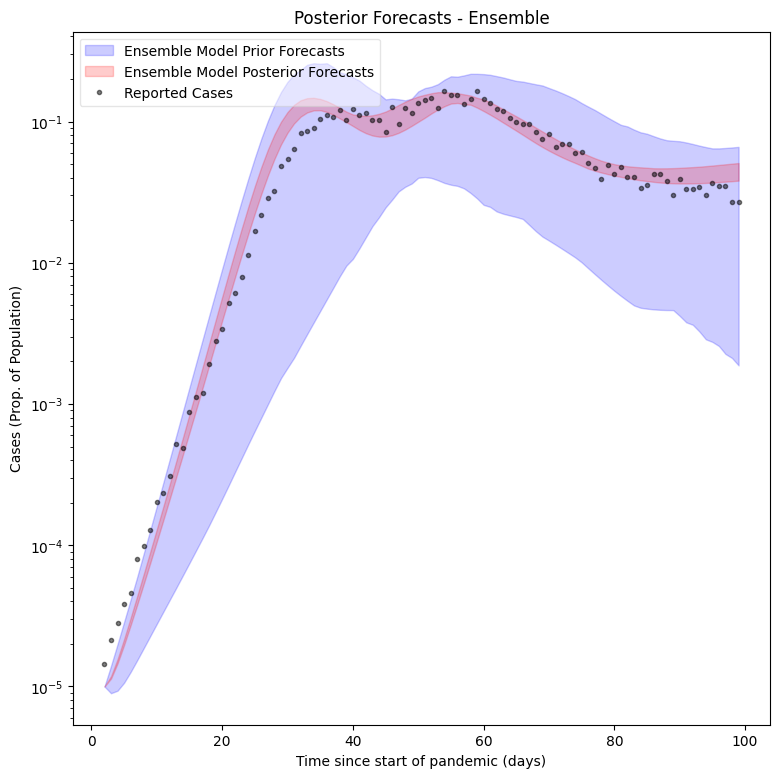

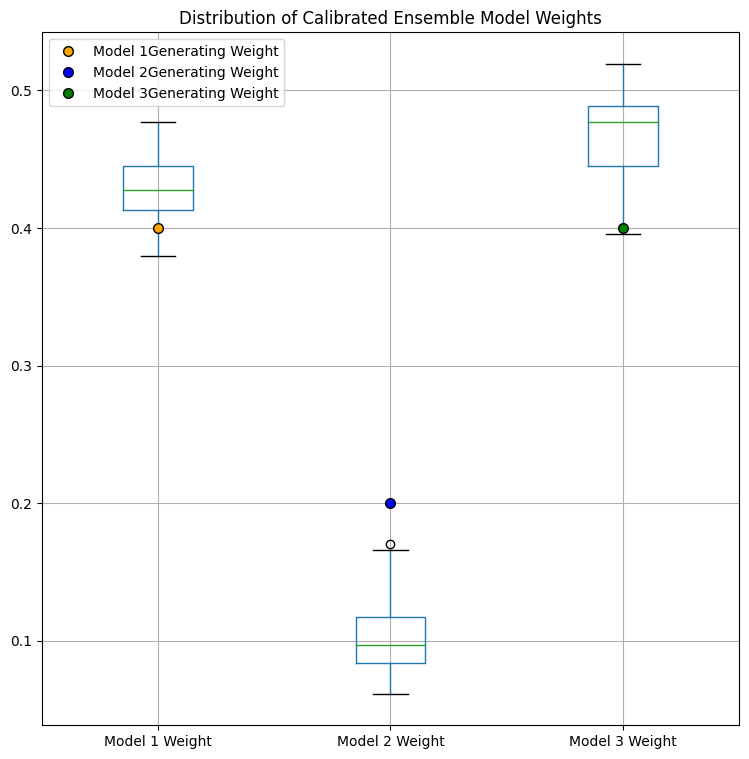

In [30]:
# Using different generating_weights
ensemble_weight_comparison([0.4, 0.2, 0.4], 0.1, [1, 2, 3], [1/3, 1/3, 1/3], model1_sample, model2_sample, model3_sample)

dict_keys(['model0', 'model1', 'model2'])


Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [SIRHD(), SEIARHDS(), SEIARHD()]

iteration 0: loss = -773.9285521507263
iteration 10: loss = -857.7998123168945
iteration 20: loss = -884.5738011598587
iteration 30: loss = -910.402987241745
iteration 40: loss = -917.7631229162216
iteration 50: loss = -929.037833571434
iteration 60: loss = -933.9786541461945
iteration 70: loss = -945.4999996423721
iteration 80: loss = -943.4766290187836
iteration 90: loss = -945.9145604372025


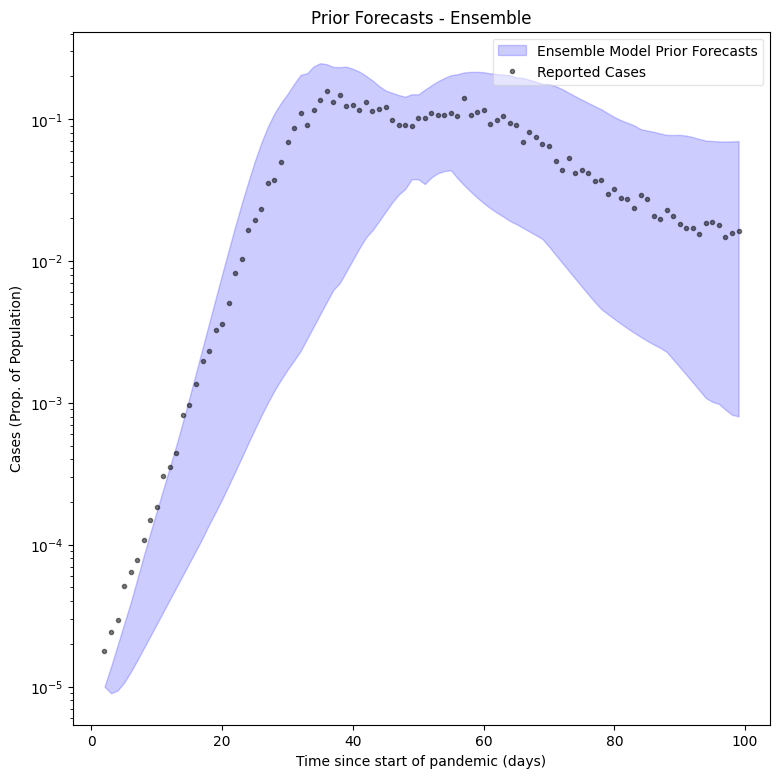

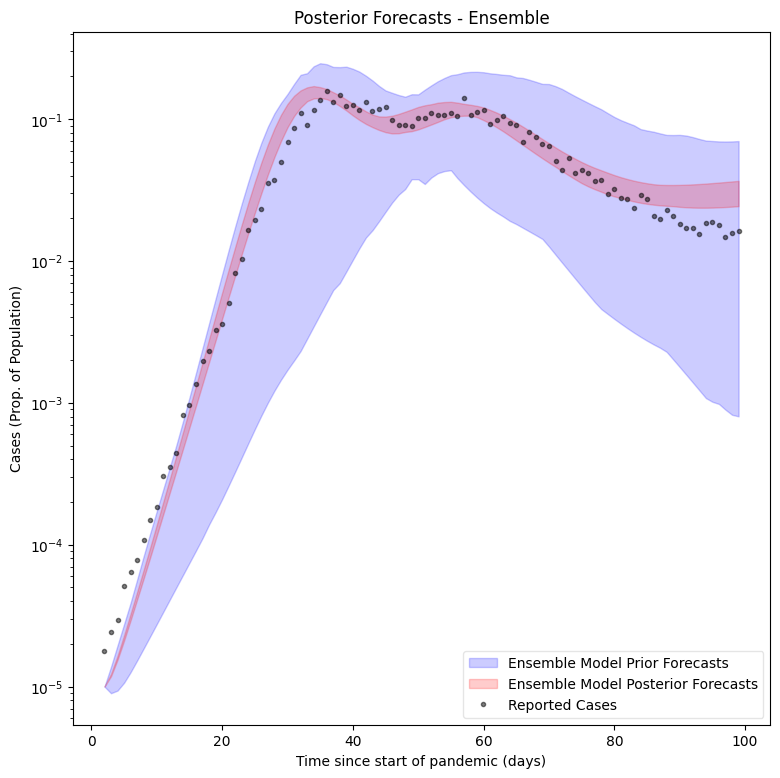

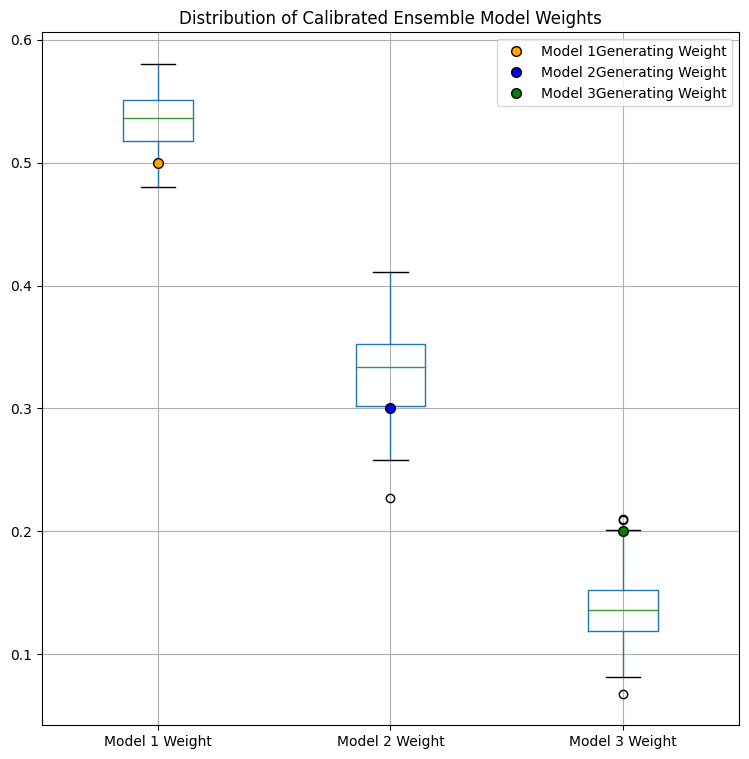

In [31]:
# Using different generating_weights and switching order of model inputs
ensemble_weight_comparison([0.5, 0.2, 0.3], 0.1, [1, 3, 2], [1/3, 1/3, 1/3], model1_sample, model3_sample, model2_sample)

dict_keys(['model0', 'model1', 'model2'])


Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [SIRHD(), SEIARHD(), SEIARHDS()]

iteration 0: loss = -830.0008445978165
iteration 10: loss = -893.177120089531
iteration 20: loss = -928.4220793247223
iteration 30: loss = -949.3897780179977
iteration 40: loss = -976.6131607294083
iteration 50: loss = -984.3920315504074
iteration 60: loss = -994.2128158807755
iteration 70: loss = -1009.0780291557312
iteration 80: loss = -1016.6962604522705
iteration 90: loss = -1018.4484493732452


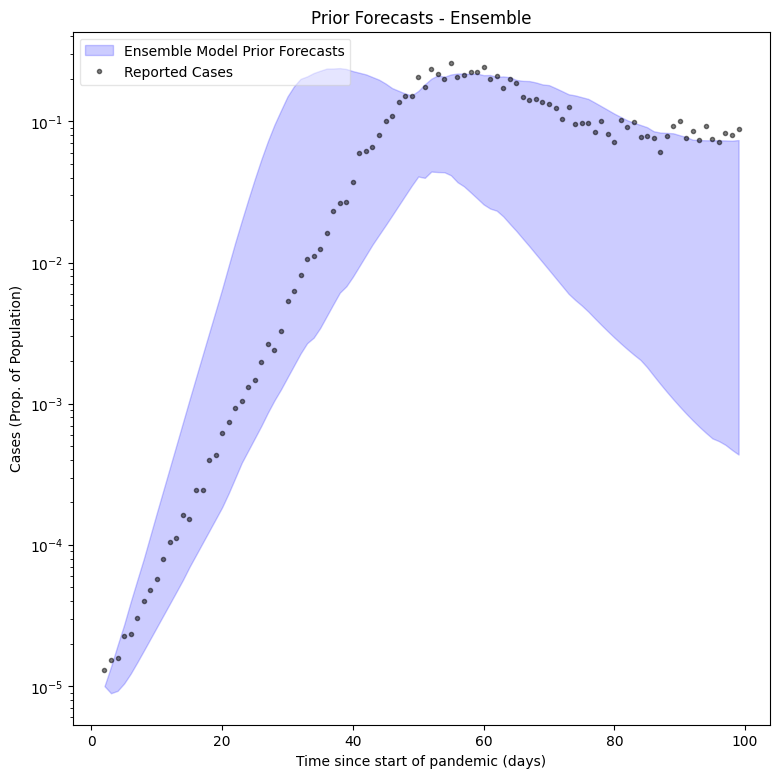

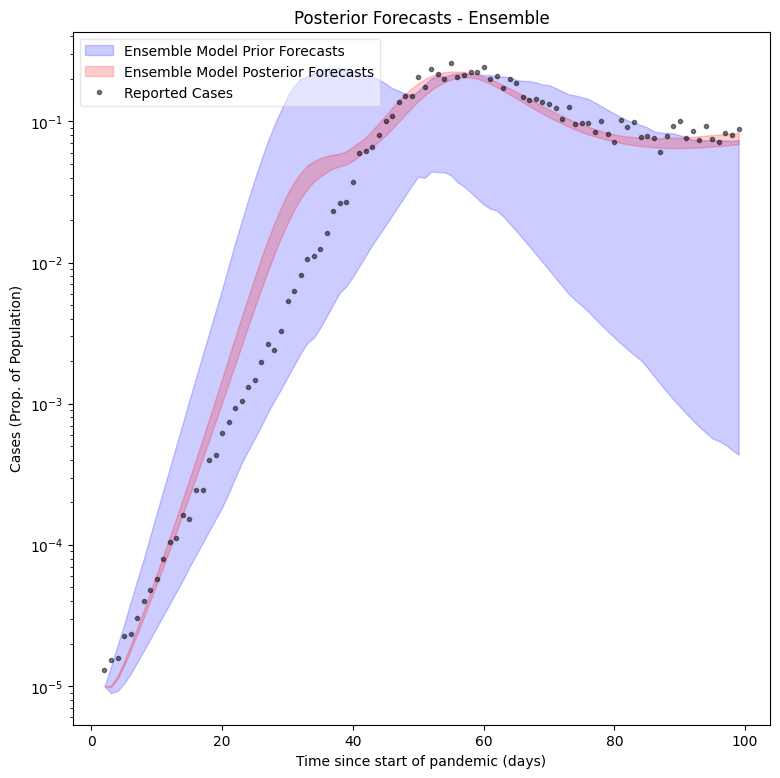

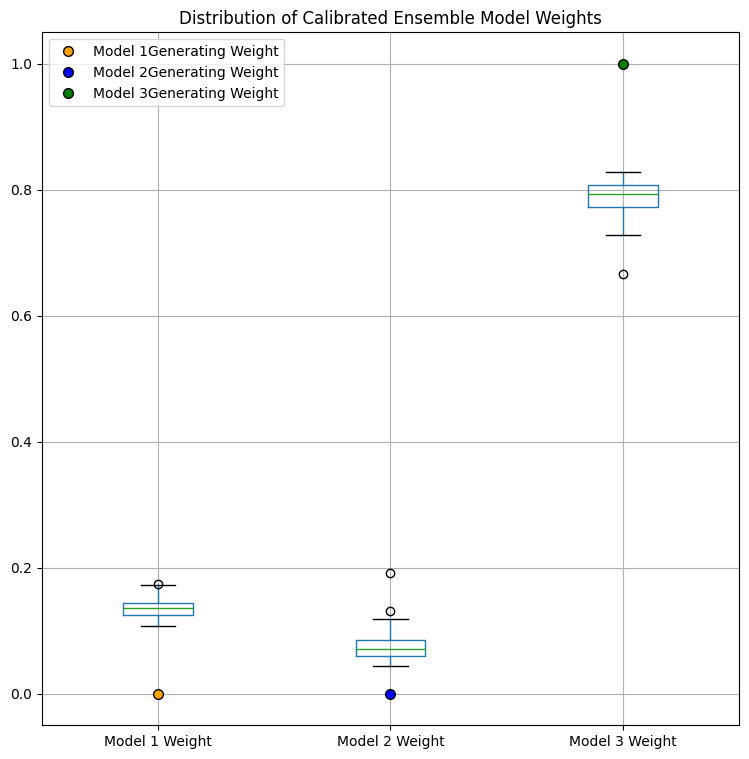

In [32]:
# Calibrate ensemble of three models to data generated by Model 3 only
ensemble_weight_comparison([0, 0, 1], 0.1, [1, 2, 3], [1/3, 1/3, 1/3], model1_sample, model2_sample, model3_sample)

dict_keys(['model0', 'model1', 'model2'])


Ensemble of 1 models. 

 	Dirichlet Alpha: tensor([1.]). 

 	Models: [SEIARHDS()]

iteration 0: loss = 1320.6773254573345
iteration 10: loss = 1146.2513729035854
iteration 20: loss = 1026.050635188818
iteration 30: loss = 931.6004547774792
iteration 40: loss = 811.81934055686
iteration 50: loss = 695.2426469027996
iteration 60: loss = 614.360107511282
iteration 70: loss = 541.2736540138721
iteration 80: loss = 484.14162012934685
iteration 90: loss = 474.4453473985195


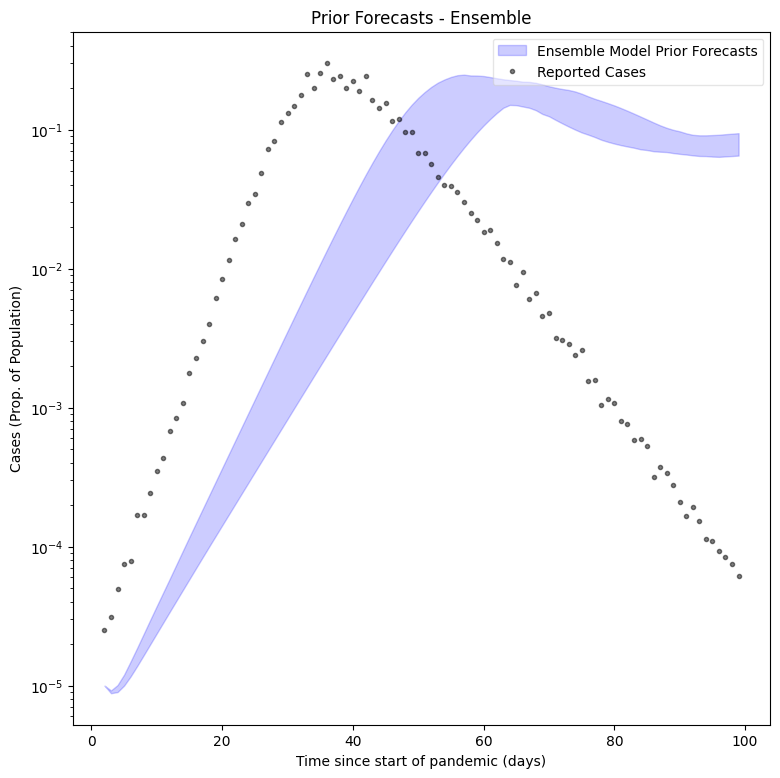

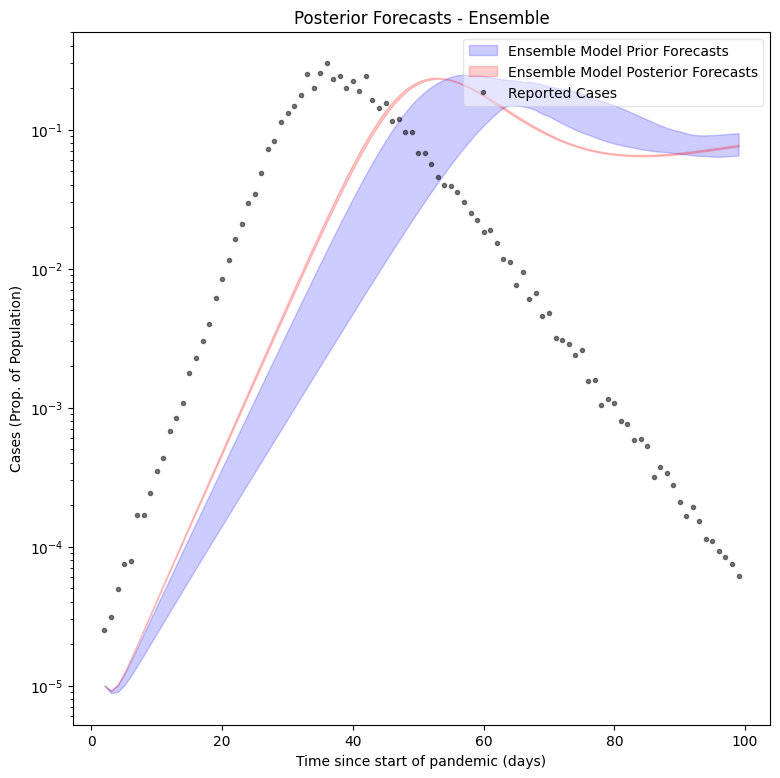

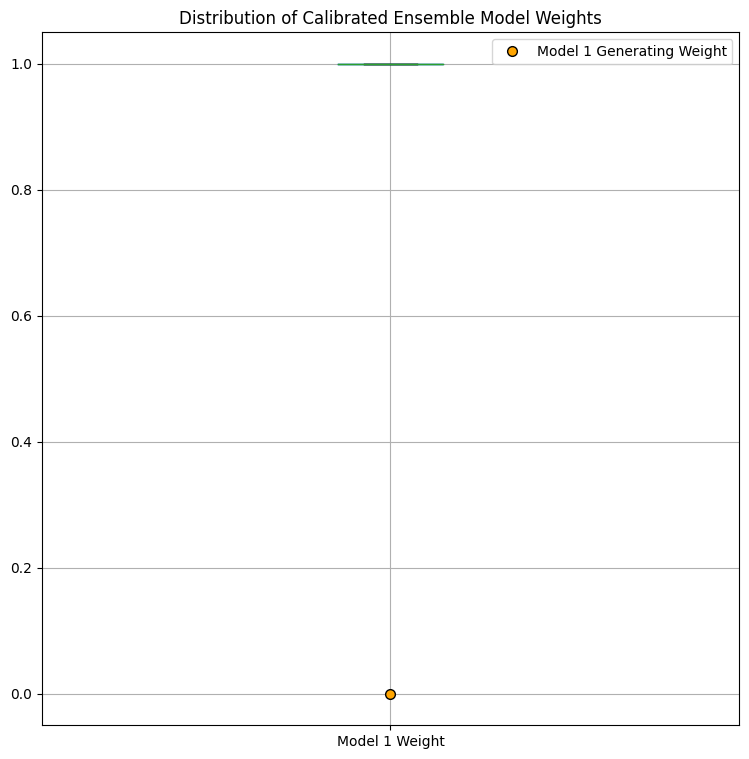

In [36]:
# Calibrate ensemble of Model 3 only to data generated by Model 1 only
ensemble_weight_comparison([1, 0, 0], 0.1, [3], [0, 0, 1], model1_sample, model2_sample, model3_sample)

dict_keys(['model0', 'model1', 'model2'])


Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [SIRHD(), SEIARHD(), SEIARHDS()]

iteration 0: loss = -766.7321135997772
iteration 10: loss = -858.3732368946075
iteration 20: loss = -895.5303100347519
iteration 30: loss = -908.8068633079529
iteration 40: loss = -924.1898820400238
iteration 50: loss = -929.4578607082367
iteration 60: loss = -931.6857050657272
iteration 70: loss = -936.748474240303
iteration 80: loss = -938.547142624855
iteration 90: loss = -940.7027269601822


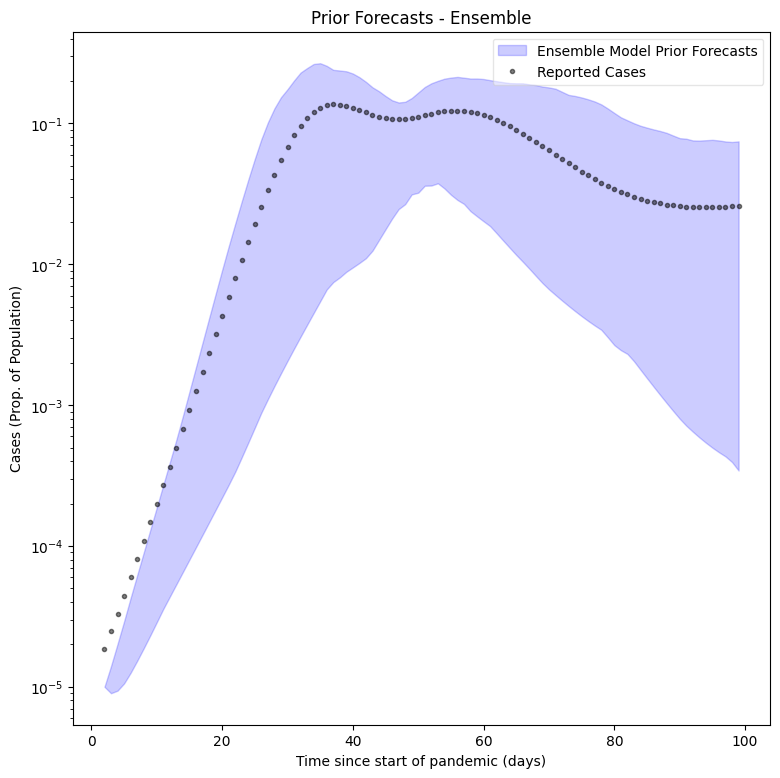

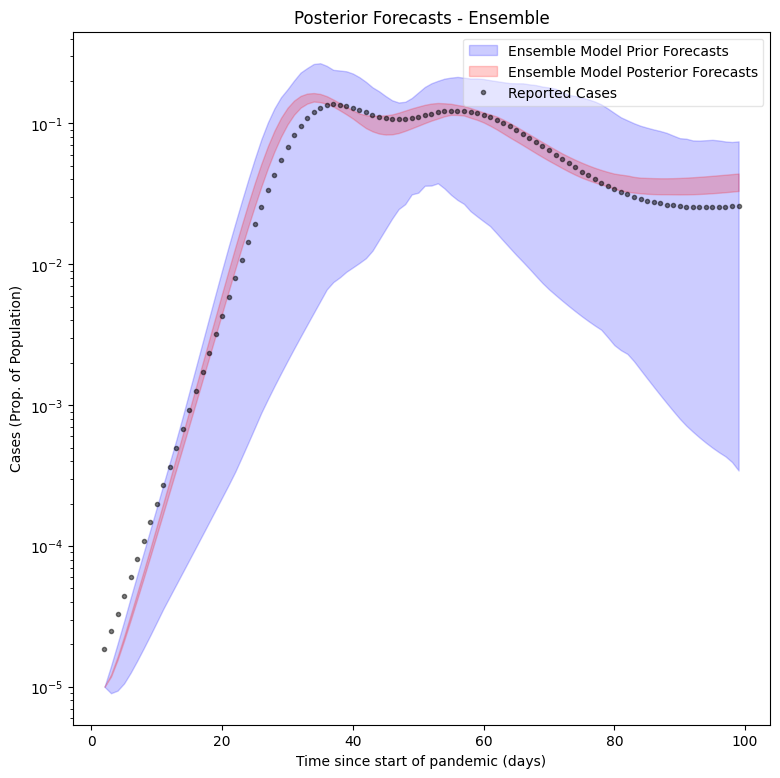

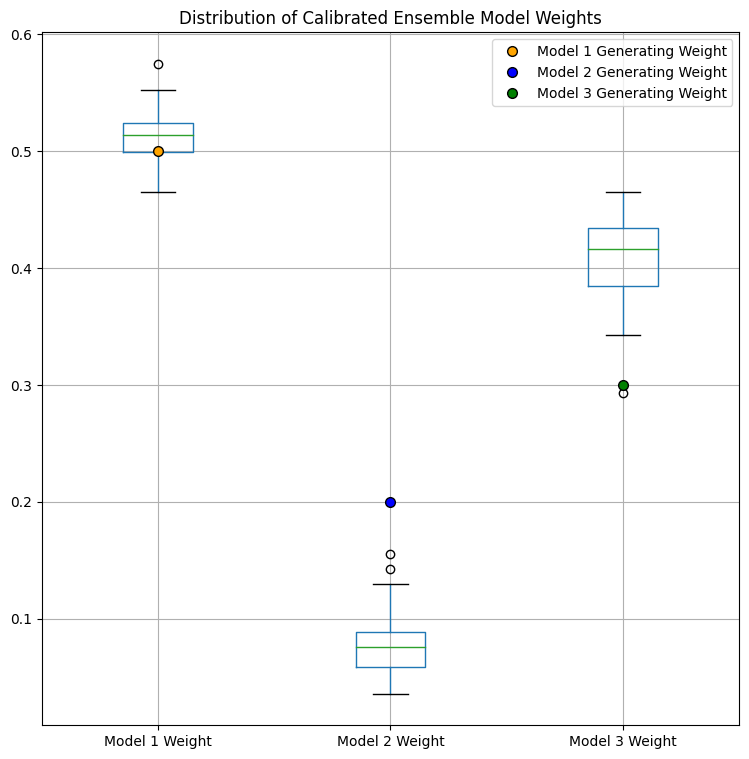

In [37]:
# Calibrate ensemble model to synthetic data with zero noise added
ensemble_weight_comparison([0.5, 0.2, 0.3], 0.0, [1, 2, 3], [1/3, 1/3, 1/3], model1_sample, model2_sample, model3_sample)